## Abalone Data Clustering

##### Original Paper:
Gholizadeh, N., Saadatfar, H. & Hanafi, N. *K-DBSCAN: An improved DBSCAN algorithm for big data*. J Supercomput 77, 6214–6235 (2021). https://doi.org/10.1007/s11227-020-03524-3

Steps:
1. Load the abalone dataset from the uciml repo python library
2. Extract the features
3. Perform KMeans clustering using KMeans++ for the initialised centroids
4. Merge clusters based on a defined distance formula and *ε* such that two clusters are merged if the distance between them, *d* < *ε*
5. On each of the clusters obtained in step 4, perform DBSCAN

References:
1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
3. http://archive.ics.uci.edu/dataset/1/abalone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN 
from scipy.spatial.distance import cdist

In [2]:
# Fetch the abalone dataset 
abalone = fetch_ucirepo(id=1) 
  
# data is stored as a pandas dataframe
X = abalone.data.features 
y = abalone.data.targets

In [3]:
# Features
X.head(10)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320


In [4]:
# Checking the stats of the features

X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
dtypes: float64(7), object(1)
memory usage: 261.2+ KB


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [5]:
# Target column to be discarded
y.head()

,Rings
0,15
1,7
2,9
3,10
4,7


In [7]:
# Scaling/standardizing the features

scaled_X = X
scaler = StandardScaler()
scaled_X[
    ['Length', 'Diameter', 'Height',
     'Whole_weight', 'Shucked_weight',
     'Viscera_weight', 'Shell_weight']] = scaler.fit_transform(scaled_X[
    ['Length', 'Diameter', 'Height',
     'Whole_weight', 'Shucked_weight',
     'Viscera_weight', 'Shell_weight']])

scaled_X

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2699034783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_X[


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [8]:
# Creating a dataframe to store scaled features

abalone = scaled_X
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757


In [9]:
# Label encoding the Sex column

abalone['Sex'] = LabelEncoder().fit_transform(abalone['Sex'])
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757


In [10]:
# # Alternative - dropping the Sex column
# abalone = abalone.drop(['Sex'], axis=1)
# abalone

#### KMeans++ clustering on abalone dataset

In [11]:
# number of clusters as proposed in the paper = sqrt(n_samples)
import math
num_clusters = math.floor(np.sqrt([len(abalone)])[0])
num_clusters

64

In [12]:
# Checking our dataset
abalone

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,0,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,2,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,2,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,0,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [13]:
# Running KMeans++ with num_clusters
start = time.time()
km_abalone = KMeans(init='k-means++', n_clusters=num_clusters, random_state=69, n_init='auto', max_iter=4).fit(abalone)
km_abalone.labels_

array([25, 22, 61, ..., 15,  9, 49])

In [14]:
# Retrieving KMeans cluster centroids
km_abalone.cluster_centers_

array([[ 1.00000000e+00,  5.04365375e-01,  4.64775587e-01,
         1.07206622e-01,  1.68621153e-01,  3.20708829e-01,
         4.05080271e-02,  1.19522125e-01],
       [ 1.00000000e+00, -1.20676342e+00, -1.24067645e+00,
        -1.10541414e+00, -1.17783432e+00, -1.10982412e+00,
        -1.16272950e+00, -1.16251016e+00],
       [ 1.97959184e+00,  1.15900118e+00,  1.12888217e+00,
         9.48477529e-01,  1.46103652e+00,  1.62645371e+00,
         1.49157060e+00,  1.12267736e+00],
       [-2.22044605e-16,  1.24215412e+00,  1.26148183e+00,
         8.57298279e-01,  1.52663239e+00,  1.66573894e+00,
         1.25200542e+00,  1.36137218e+00],
       [ 1.00000000e+00, -1.79433037e-01, -2.46543231e-01,
        -4.03865909e-01, -5.07999355e-01, -4.40598138e-01,
        -5.12421305e-01, -5.10159899e-01],
       [ 0.00000000e+00, -5.74558133e-01, -5.32926814e-01,
         2.36832870e+01, -4.78742906e-01, -1.23312315e-01,
        -5.89351669e-01, -7.56763290e-01],
       [ 2.00000000e+00,  7.343197

In [17]:
# Creating a column to store predicted clusters

cluster = []
for val in km_abalone.labels_:
    cluster_label = "KC"+str(val)
    cluster.append(cluster_label)
# cluster

In [25]:
# Appending the predicted clusters to our dataset
clustered_abalone = abalone.copy()
clustered_abalone['cluster'] = cluster
clustered_abalone.head(10)

clustered_abalone

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,cluster
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,KC25
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,KC22
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,KC61
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,KC27
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,KC40
...,...,...,...,...,...,...,...,...,...
4172,0,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,KC57
4173,2,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,KC54
4174,2,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,KC15
4175,0,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,KC9


In [26]:
# Storing the samples in each cluster in a dictionary with the cluster name as key and a dataframe with samples belonging
# to those clusters as the value

cluster_samples = {}
labels = set(cluster)
for label in labels:
    cluster_samples[label] = clustered_abalone.loc[clustered_abalone['cluster'] == label]

In [28]:
# We create a similar dictionary to store features of each sample in each cluster

cluster_features = {}
for label in labels:
    cluster_features[label] = cluster_samples[label].drop(['cluster'], axis=1)
# abalone = abalone.drop(['cluster'], axis=1)
cluster_features["KC63"]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
59,0,-0.158164,-0.079426,-0.347099,-0.501177,-0.510811,-0.461616,-0.458601
68,0,-0.408000,-0.180204,-0.466653,-0.608247,-0.657249,-0.593914,-0.494524
99,0,-0.408000,-0.331371,-0.347099,-0.510354,-0.368878,-0.872195,-0.602294
107,0,-0.199803,-0.079426,-0.347099,-0.328844,-0.443224,-0.447930,-0.135293
115,0,0.050033,0.071741,-0.586208,-0.483842,-0.569386,-0.201582,-0.422678
...,...,...,...,...,...,...,...,...
3932,0,-0.283082,-0.381760,-0.586208,-0.586833,-0.848745,-0.575666,-0.386755
3936,0,-0.408000,-0.079426,-0.586208,-0.586833,-0.781159,-0.712526,-0.207139
3942,0,0.008394,-0.079426,-0.586208,-0.406343,-0.468006,-0.333880,-0.422678
3951,0,-0.491279,-0.180204,-0.705762,-0.394106,-0.801435,-0.215268,-0.099370


In [29]:
# Running DBSCAN on each cluster and storing the results
dbscan_clusters = {}

# Running DBSCAN on each cluster:
selected_df = None
for i in range(0, num_clusters):
    label = "KC" + str(i)
    
    current = cluster_features[label] # current dataframe    
    n = len(cluster_features[label]) # total number of samples in the current kmeans cluster
    
    dbscan = DBSCAN(eps=0.3, min_samples=4).fit(cluster_features[label])
    valid_clus = set(dbscan.labels_).difference([-1]) # removing noise points
    numclu = len(set(valid_clus)) # total number of non-noise DBSCAN clusters identified in the current KMeans cluster
    
    #print("# DBSCAN clusters found: ", numclu)
    
    current['db_clus'] = dbscan.labels_ # marking each sample with it's dbscan cluster number
    
    db_samples = {}
    if numclu > 0:
        for p in range(numclu):
            db_samples[str(p)] = current.loc[current['db_clus'] == p].drop(['db_clus'], axis=1)

    dbscan_clusters[label] = db_samples

In [30]:
# Checking if everything has worked properly
dbscan_clusters["KC0"]["0"]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
1650,1,0.549706,0.525242,0.131117,0.148385,0.268692,-0.019102,0.152092
2912,1,0.508067,0.424464,-0.107991,0.053551,0.090713,0.058452,0.152092
3567,1,0.466427,0.525242,0.011563,0.199371,0.243910,0.035642,0.223939
3671,1,0.591345,0.626020,-0.107991,0.219766,0.336279,0.031080,0.346077


### Merging clusters

In this step, we examine each of the groups obtained from KMeans clustering to see if any of the clusters can be merged. The authors proposed the following distance formula for calculating pairwise distances between the groups:
<br><br>
<div style="text-align: center;">
    <i>
        <strong>dis_K<sub>ij</sub> = dis_KC<sub>ij</sub> - (dis_r<sub>i</sub> + dis_r<sub>j</sub></strong>
    </i>, where
    <br><br>
    <i><strong>dis_K<sub>ij</sub></strong></i> = distance between clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_KC<sub>ij</sub></strong></i> = distance between the cluster centers of clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_r<sub>i</sub></strong></i> = distance of the furthest point in cluster <i>i</i> to the corresponding center, and
    <br>
    <i><strong>dis_r<sub>j</sub></strong></i> = distance of the furthest point in cluster <i>j</i> to the corresponding center
</div>

In [31]:
# We will be using the Euclidean distance when calculating distance between KMeans groups
from scipy.spatial import distance

In [32]:
# Defining a function to calculate distance between two groups/clusters
def minC_distance(a, b):
    return np.min(cdist(a, b))

##### Saving centers and farthest point of each cluster in a dictionary

In [33]:
km_centers = {}
farthest_point = {}

for i in range(0, num_clusters):
    # finding the center of cluster i
    label = "KC" + str(i)
    center = km_abalone.cluster_centers_[i]
    km_centers[label] = center
    
    # iterating through each sample in cluster i to find the farthest point
    samples = cluster_features[label].drop(['db_clus'], axis=1).to_numpy() 
    max_dist = 0
    for sample in samples:        
        dist = distance.euclidean(np.array(sample), center)
        if dist >= max_dist:
            farthest_point[label] = {"point": np.array(sample),"distance": dist}
            max_dist = dist

##### Computing pairwise distances of each cluster using the distance formula defined earlier

In [34]:
# Initialise the matrix with infinity values
pairwise_distance = np.full((num_clusters, num_clusters), np.inf)

for i in range(0, num_clusters):
    ci = "KC" + str(i) # label of cluster i
    
    for j in range(i + 1, num_clusters):
        cj = "KC" + str(j) # label of cluster j
        if i == j:
            pairwise_distance[i][j] = 0
        else:
            pairwise_distance[i][j] = distance.euclidean(km_centers[ci], km_centers[cj]) 
            - (farthest_point[ci]["distance"] + farthest_point[cj]["distance"])
pairwise_distance

# utility function that returns the pairwise distance of two groups
def pair_dist_group(i, j):
    return pairwise_distance[i][j]

In [35]:
# Scratchpad
# s = '2'
# type(int(s))

In [36]:
# cluster_samples - contains list of KMeans groups
# dbscan_clusters - contains dbscan clusters for each KMeans group

counter = 1
flag = {}
flag_ref = {}
k = num_clusters # number of kmeans groups
epsilon = 3.0 # distance above which clusters will be pruned
MinPts = 4

# temp = []

for a in range(k-1):
    label_k1 = "KC" + str(a)
    num_1 = len(dbscan_clusters[label_k1]) # # of dbscan clusters in group a
    for b in range(k):
        label_k2 = "KC" + str(b)
        num_2 = len(dbscan_clusters[label_k2]) # of dbscan clusters in group b
        dis_k = pair_dist_group(a, b)
        if dis_k <= epsilon:
            group1 = dbscan_clusters[label_k1]
            group2 = dbscan_clusters[label_k2]
            if num_1 > 0 and num_2 > 0:
                for c in group1.keys():
                    cluster1 = group1[c]
                    for d in group2.keys():                        
                        cluster2 = group2[d]
                        dis_db = minC_distance(cluster1, cluster2)
                        
                        # converting all keys to integers
                        int_a = int(a)
                        int_b = int(b)
                        int_c = int(c)
                        int_d = int(d)
                        
                        if dis_db <= epsilon:
                            if(int_a, int_c) not in flag and (int_b, int_d) not in flag:
                                flag[(int_a, int_c)] = counter
                                flag[(int_b, int_d)] = counter
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = counter
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = counter
                                counter += 1
                            else:
                                flag[(int_a, int_c)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag[(int_b, int_d)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))

In [37]:
# List of clusters that need to be merged
for itm in flag_ref.keys():
    print(itm)

('a_0', 'c_0')
('b_4', 'd_0')
('b_6', 'd_0')
('b_6', 'd_1')
('b_6', 'd_2')
('b_9', 'd_0')
('b_9', 'd_1')
('b_10', 'd_0')
('b_11', 'd_0')
('b_12', 'd_0')
('b_12', 'd_1')
('b_12', 'd_2')
('b_14', 'd_0')
('b_15', 'd_0')
('b_15', 'd_1')
('b_15', 'd_2')
('b_15', 'd_3')
('b_15', 'd_4')
('b_16', 'd_0')
('b_19', 'd_0')
('b_19', 'd_1')
('b_20', 'd_0')
('b_24', 'd_0')
('b_24', 'd_1')
('b_24', 'd_2')
('b_27', 'd_0')
('b_27', 'd_1')
('b_28', 'd_0')
('b_29', 'd_0')
('b_31', 'd_0')
('b_31', 'd_1')
('b_32', 'd_0')
('b_36', 'd_0')
('b_36', 'd_1')
('b_36', 'd_2')
('b_38', 'd_0')
('b_38', 'd_1')
('b_38', 'd_2')
('b_39', 'd_0')
('b_41', 'd_0')
('b_44', 'd_0')
('b_45', 'd_0')
('b_45', 'd_1')
('b_51', 'd_0')
('b_54', 'd_0')
('b_55', 'd_0')
('b_57', 'd_0')
('b_61', 'd_0')
('b_61', 'd_1')
('b_62', 'd_0')
('b_62', 'd_1')
('b_62', 'd_2')
('b_63', 'd_0')
('a_1', 'c_0')
('b_7', 'd_0')
('b_17', 'd_0')
('b_17', 'd_1')
('b_22', 'd_0')
('b_25', 'd_0')
('b_25', 'd_1')
('b_34', 'd_0')
('b_40', 'd_0')
('b_46', 'd_0')
(

In [38]:
abalone

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,0,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,2,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,2,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,0,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [39]:
# Create an empty dataset to store the merged clusters

final_data = pd.DataFrame(columns=abalone.columns)
final_data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight


In [41]:
# Appending all the clusters to be merged to final_data
for tup in flag_ref.keys():
    group = tup[0].split('_')[1]
    cluster = tup[1].split('_')[1]
    samples = dbscan_clusters['KC'+str(group)][str(cluster)]
    final_data = final_data.append(samples)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipy

In [42]:
# Checking if everything worked
final_data

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
1650,1,0.549706,0.525242,0.131117,0.148385,0.268692,-0.019102,0.152092
2912,1,0.508067,0.424464,-0.107991,0.053551,0.090713,0.058452,0.152092
3567,1,0.466427,0.525242,0.011563,0.199371,0.243910,0.035642,0.223939
3671,1,0.591345,0.626020,-0.107991,0.219766,0.336279,0.031080,0.346077
50,1,-0.033246,0.021352,-0.466653,-0.476703,-0.544604,-0.634972,-0.350832
...,...,...,...,...,...,...,...,...
2834,0,0.383148,0.172519,-0.227545,-0.095328,0.045655,-0.055598,-0.304132
2900,0,0.216591,0.273297,0.011563,-0.170787,-0.055725,-0.060160,-0.088593
3304,0,0.383148,0.273297,0.011563,-0.041283,-0.161612,0.021956,-0.135293
3901,0,0.008394,0.222908,-0.347099,-0.032105,-0.125565,-0.133152,-0.440640


In [43]:
# Remove duplicates created while merging
final_data = final_data.drop_duplicates()
final_data

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
1650,1,0.549706,0.525242,0.131117,0.148385,0.268692,-0.019102,0.152092
2912,1,0.508067,0.424464,-0.107991,0.053551,0.090713,0.058452,0.152092
3567,1,0.466427,0.525242,0.011563,0.199371,0.243910,0.035642,0.223939
3671,1,0.591345,0.626020,-0.107991,0.219766,0.336279,0.031080,0.346077
50,1,-0.033246,0.021352,-0.466653,-0.476703,-0.544604,-0.634972,-0.350832
...,...,...,...,...,...,...,...,...
3623,2,1.132658,1.230689,0.848442,1.538265,1.712799,1.550225,1.193864
3510,2,1.049379,0.978743,0.967997,1.305768,1.586637,1.395117,1.014248
3511,2,1.091018,1.129911,0.967997,1.352676,1.618178,1.636903,0.834632
3828,2,1.299216,1.129911,0.848442,1.456687,1.771375,1.554787,0.971140


##### Run DBSCAN algorithm in the clusters with same flag

In [44]:
labels = DBSCAN(eps=0.6, min_samples=4).fit(final_data).labels_
print("Took ", round((time.time() - start), 2), "seconds.")
print("FINAL LABELS ->", labels)
labels

Took  344.98 seconds.
FINAL LABELS -> [0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [45]:
# storing cluster assigned to each point in a new column
final_data['cluster'] = labels
final_data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11832\2174565346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['cluster'] = labels


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,cluster
1650,1,0.549706,0.525242,0.131117,0.148385,0.268692,-0.019102,0.152092,0
2912,1,0.508067,0.424464,-0.107991,0.053551,0.090713,0.058452,0.152092,0
3567,1,0.466427,0.525242,0.011563,0.199371,0.243910,0.035642,0.223939,0
3671,1,0.591345,0.626020,-0.107991,0.219766,0.336279,0.031080,0.346077,0
50,1,-0.033246,0.021352,-0.466653,-0.476703,-0.544604,-0.634972,-0.350832,0
...,...,...,...,...,...,...,...,...,...
3623,2,1.132658,1.230689,0.848442,1.538265,1.712799,1.550225,1.193864,1
3510,2,1.049379,0.978743,0.967997,1.305768,1.586637,1.395117,1.014248,1
3511,2,1.091018,1.129911,0.967997,1.352676,1.618178,1.636903,0.834632,1
3828,2,1.299216,1.129911,0.848442,1.456687,1.771375,1.554787,0.971140,1


In [46]:
# Number of clusters obtained:
print("Number of clusters found = ",len(final_data['cluster'].unique()))

Number of clusters found =  3


### Results

#### Davies-Boulding (DB) metric

This is a metric based on the ratio of within-cluster and between-cluster distances. It is defined as follows:
<div style="text-align: center;">D<sub>ij</sub> = $\frac{1}{k}$$\sum_{i=1}^{k}$ max$_{(j≠i)}${D<sub>i.j</sub>}</div>

In this equation, ${k}$ represents the number of clusters and D<sub>i.j</sub> indicates within-to between cluster distance ratio, which is defined as follows:

<div style="text-align: center;">D<sub>i.j</sub> = $\frac{(\bar{d_{i}} - \bar{d_{j}})}{d_{i.j}}$</div>

where:
<div style="text-align: center;">
$d_{i.j}$ = Euclidean distance between the centers of clusters ${i}$ and ${j}$
</div>
<div style="text-align: center;">
$d_{i}$ = mean distance between all the pieces of data in cluster ${i}$ and the center of cluster ${i}$
</div>
<div style="text-align: center;">
$d_{j}$ = mean distance between all the pieces of data in cluster ${i}$ and the center of cluster ${j}$
</div>

A smaller value for the DB metric shows higher clustering quality.

In [48]:
# Calculating Davies-Bouldin (DB) metric

##### Cluster visualisation

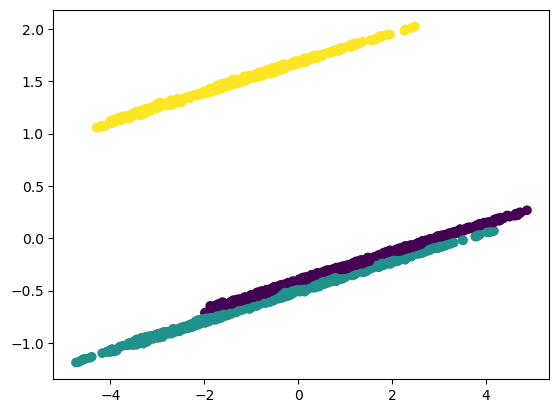

In [50]:
# Performing PCA so that we can plot the results

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 3)
Xt = pca.fit_transform(final_data)

# 2-D plot
plot = plt.scatter(Xt[:,0], Xt[:, 1], c=labels)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


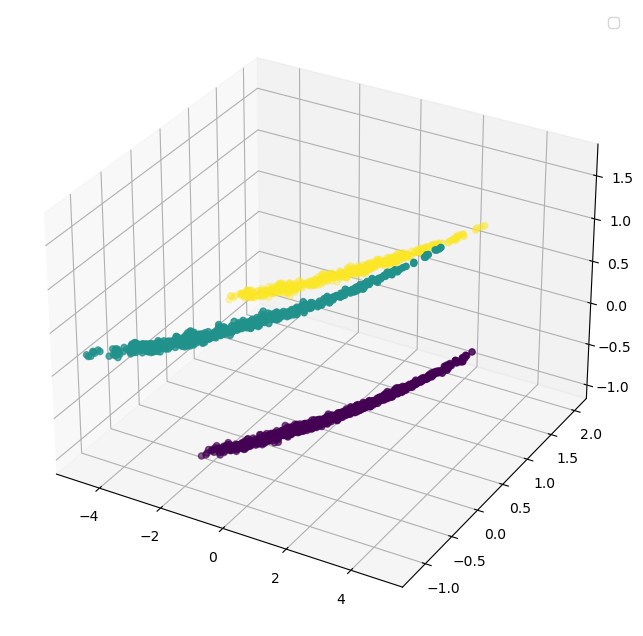

In [51]:
# 3-D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], c=labels)
plt.legend()
plt.show()

### Performing traditional DBSCAN and KMeans over the entire dataset

#### DBSCAN

In [53]:
from sklearn.preprocessing import LabelEncoder
df2 = pd.read_csv("telescope_data.csv").drop(['Unnamed: 0'], axis=1)
scaler = StandardScaler()
le = LabelEncoder()
df2['class'] = le.fit_transform(df2['class'])
scaled_X = scaler.fit_transform(df2.drop(['class'], axis=1))
scaled_X

array([[-0.57722602, -0.33680419, -0.38113037, ..., -0.40584194,
         0.47681587, -1.49786555],
       [-0.51096889, -0.57002666, -0.64859479, ..., -0.49009359,
        -0.81541816,  0.15312459],
       [ 2.56827756,  6.20585836,  2.61578306, ..., -2.18302986,
         1.88922413,  0.84263513],
       ...,
       [ 0.52392318,  1.38177927,  1.31887687, ..., -0.4665087 ,
         0.10163583,  0.83900338],
       [ 1.58775746,  2.98278123,  2.47337518, ..., -3.07720555,
         2.18525981,  2.87032093],
       [ 3.16145936,  1.67999288,  0.81314905, ...,  1.49930076,
         0.96101431,  1.05044239]])

In [60]:
start = time.time()

# Create DBSCAN model and print the time taken to finish running
dbscan = DBSCAN(eps=1.0, min_samples=4).fit(scaled_X)
print("Took ", round((time.time() - start), 2), "seconds.")

Took  4.69 seconds.


In [61]:
# Check labels
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

In [62]:
df2["DBSCAN"] = dbscan.labels_
df2

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,DBSCAN
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0,-1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1,-1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1,-1


#### KMeans++ with k = 3

In [63]:
km = KMeans(n_clusters=3, init="k-means++", random_state=0, n_init="auto", max_iter=300).fit(scaled_X)
km.labels_

array([0, 0, 1, ..., 2, 1, 1])

In [64]:
df2['KMeans++'] = km.labels_
df2

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,DBSCAN,KMeans++
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0,0,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0,0,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0,-1,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0,0,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1,0,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1,0,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1,-1,2
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1,-1,1


#### HDBSCAN

In [65]:
# from sklearn.cluster import HDBSCAN
# hdbscan = HDBSCAN(min_samples=4).fit(scaled_X)